In [116]:
import os
import rioxarray as rxr
#import earthpy as et
import pandas as pd
import rasterio
import numpy as np
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import glob
from ast import literal_eval
from plotly.subplots import make_subplots
import missingno as msno

from scipy.stats import ttest_ind
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Read geotiff

In [2]:
rasternames = glob.glob("Raster2\*.tif")
rasternames

['Raster2\\Cobertura.tif',
 'Raster2\\Curvatura.tif',
 'Raster2\\Distancia_Drenajes.tif',
 'Raster2\\Distancia_Fallas.tif',
 'Raster2\\Distancia_Vias.tif',
 'Raster2\\DTM.tif',
 'Raster2\\Geologia.tif',
 'Raster2\\Geomorfologia.tif',
 'Raster2\\NDVI.tif',
 'Raster2\\Orientaciones.tif',
 'Raster2\\Rugosidad.tif',
 'Raster2\\Slope.tif',
 'Raster2\\TPI.tif',
 'Raster2\\UGS.tif']

In [3]:
img_data = {}
for i in rasternames:
    img_data[i[8:-4]] = rxr.open_rasterio(i, masked=True, sharing=False)
img_data

{'Cobertura': <xarray.DataArray (band: 1, y: 4707, x: 3182)>
 [14977674 values with dtype=float32]
 Coordinates:
   * band         (band) int32 1
   * x            (x) float64 9.659e+05 9.659e+05 ... 1.006e+06 1.006e+06
   * y            (y) float64 6.414e+05 6.414e+05 ... 5.826e+05 5.826e+05
     spatial_ref  int32 0
 Attributes:
     RepresentationType:      THEMATIC
     STATISTICS_COVARIANCES:  13.4607380518378
     STATISTICS_MAXIMUM:      24
     STATISTICS_MEAN:         12.957420420542
     STATISTICS_MINIMUM:      1
     STATISTICS_SKIPFACTORX:  1
     STATISTICS_SKIPFACTORY:  1
     STATISTICS_STDDEV:       3.6688878494494
     scale_factor:            1.0
     add_offset:              0.0,
 'Curvatura': <xarray.DataArray (band: 1, y: 4707, x: 3182)>
 [14977674 values with dtype=float32]
 Coordinates:
   * band         (band) int32 1
   * x            (x) float64 9.659e+05 9.659e+05 ... 1.006e+06 1.006e+06
   * y            (y) float64 6.414e+05 6.414e+05 ... 5.826e+05 5.826e+

In [4]:
img_resolution = []
for i in img_data:
    img_resolution.append(img_data[i].rio.resolution())
img_resolution

[(12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5),
 (12.5, -12.5)]

In [5]:
img_boundries = []
for i in img_data:
    img_boundries.append(img_data[i].rio.bounds())
img_boundries

[(965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 641441.376257088),
 (965892.7168672234, 582603.876257088, 1005667.7168672234, 64144

In [6]:
img_shape = []
for i in img_data:
    img_shape.append(img_data[i].shape)
img_shape

[(1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182),
 (1, 4707, 3182)]

## Process geotiff to create Dataframe

In [7]:
df_dict = {}
for i in img_data:
    df = pd.DataFrame(img_data[i].data[0,:,:], columns=img_data[i].x.data.tolist()) 
    df["coord_y"] = pd.DataFrame(img_data[i].y.data)
    df = df.melt(id_vars=["coord_y"], var_name="coord_x", value_name=i)
    df_dict['df_'+str(i)] = df

In [8]:
df_full = pd.DataFrame(df_dict['df_Cobertura'])
for i in df_dict:
    if i != 'df_Cobertura':
        df_full = pd.merge(df_full, df_dict[i], how="outer", on=["coord_y", "coord_x"])
df_full

,coord_y,coord_x,Cobertura,Curvatura,Distancia_Drenajes,Distancia_Fallas,Distancia_Vias,DTM,Geologia,Geomorfologia,NDVI,Orientaciones,Rugosidad,Slope,TPI,UGS
0,641435.126257,965898.966867,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,255.0,NaN,NaN,NaN
1,641422.626257,965898.966867,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,255.0,NaN,NaN,NaN
2,641410.126257,965898.966867,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,255.0,NaN,NaN,NaN
3,641397.626257,965898.966867,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,255.0,NaN,NaN,NaN
4,641385.126257,965898.966867,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,255.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14977669,582660.126257,1005661.466867,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,255.0,NaN,NaN,NaN
14977670,582647.626257,1005661.466867,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,255.0,NaN,NaN,NaN
14977671,582635.126257,1005661.466867,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,255.0,NaN,NaN,NaN
14977672,582622.626257,1005661.466867,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,255.0,NaN,NaN,NaN


In [9]:
df_full['coord_x'] = pd.to_numeric(df_full['coord_x'], errors='coerce')

In [10]:
df_full_1 = df_full.dropna()
df_full_1

,coord_y,coord_x,Cobertura,Curvatura,Distancia_Drenajes,Distancia_Fallas,Distancia_Vias,DTM,Geologia,Geomorfologia,NDVI,Orientaciones,Rugosidad,Slope,TPI,UGS
348,637085.126257,9.658990e+05,7.0,-1.972500,80.039055,8860.463867,37.500000,2551.359131,7.0,12.0,0.209492,355.292999,255.0,5.959947,15.154297,8.0
349,637072.626257,9.658990e+05,7.0,1.644063,88.388351,8852.268555,25.000000,2554.278564,7.0,12.0,0.209492,14.471906,255.0,6.341040,17.635742,8.0
350,637060.126257,9.658990e+05,7.0,0.461719,97.628120,8844.083008,12.500000,2555.000000,7.0,12.0,0.211176,348.266479,255.0,2.677247,17.758545,8.0
5053,637110.126257,9.659115e+05,7.0,2.063750,72.886902,8867.470703,63.737743,2547.096191,7.0,12.0,0.209140,63.449421,255.0,13.375040,12.150391,8.0
5054,637097.626257,9.659115e+05,7.0,2.821250,80.039055,8859.246094,51.538822,2549.342041,7.0,12.0,0.209140,48.567108,255.0,14.689607,13.618164,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975982,603747.626257,1.005661e+06,15.0,-0.000156,296.331726,5869.651855,4157.842773,3438.333252,7.0,68.0,0.064533,143.526245,255.0,2.729201,5.476807,8.0
14975983,603735.126257,1.005661e+06,15.0,0.053438,307.459351,5860.687500,4162.931641,3437.500000,7.0,68.0,0.065264,167.984711,255.0,3.938153,4.979004,8.0
14975984,603722.626257,1.005661e+06,15.0,-0.071406,297.121613,5851.735840,4168.051758,3436.250000,7.0,68.0,0.065264,172.914139,255.0,4.786650,4.131836,40.0
14975985,603710.126257,1.005661e+06,15.0,0.342500,285.591492,5842.797363,4173.203125,3434.761719,7.0,68.0,0.065119,177.147964,255.0,6.341611,3.147949,40.0


In [11]:
df_full_1['partition'] = np.where(df_full_1['coord_y'] < np.percentile(df_full_1.coord_y, 10), 1,
                                  np.where(df_full_1['coord_y'] < np.percentile(df_full_1.coord_y, 20), 2,
                                           np.where(df_full_1['coord_y'] < np.percentile(df_full_1.coord_y, 30), 3, 
                                                    np.where(df_full_1['coord_y'] < np.percentile(df_full_1.coord_y, 40), 4, 
                                                        np.where(df_full_1['coord_y'] < np.percentile(df_full_1.coord_y, 50), 5,
                                                                 np.where(df_full_1['coord_y'] < np.percentile(df_full_1.coord_y, 60), 6,
                                                                          np.where(df_full_1['coord_y'] < np.percentile(df_full_1.coord_y, 70), 7,
                                                                                   np.where(df_full_1['coord_y'] < np.percentile(df_full_1.coord_y, 80), 8,
                                                                                            np.where(df_full_1['coord_y'] < np.percentile(df_full_1.coord_y, 90), 9, 10)))))))))

C:\Users\gvargasj\.conda\envs\MINE-DS\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [12]:
df_full_1.loc[:, 'slide_key'] = 0

C:\Users\gvargasj\.conda\envs\MINE-DS\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\gvargasj\.conda\envs\MINE-DS\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [13]:
df_full_1.shape

(7011573, 18)

## Save or read dataframe of Pasto

In [19]:
#df_full_1.to_csv('pastoGeo_df', sep=';', encoding='utf-8')
df_full_1 = pd.read_csv('pastoGeo_df.csv',sep=';', header='infer')

## Process slides instances

In [42]:
derrumbes_df = pd.read_csv('tablas\\Puntos_Historicos_MM.csv',sep=';', header='infer')
derrumbes_df['partition'] = np.where(derrumbes_df['Coord_Nort'] < np.percentile(df_full_1.coord_y, 10), 1,
                                     np.where(derrumbes_df['Coord_Nort'] < np.percentile(df_full_1.coord_y, 20), 2,
                                              np.where(derrumbes_df['Coord_Nort'] < np.percentile(df_full_1.coord_y, 30), 3,
                                                       np.where(derrumbes_df['Coord_Nort'] < np.percentile(df_full_1.coord_y, 40), 4,
                                                                np.where(derrumbes_df['Coord_Nort'] < np.percentile(df_full_1.coord_y, 50), 5,
                                                                         np.where(derrumbes_df['Coord_Nort'] < np.percentile(df_full_1.coord_y, 60), 6,
                                                                                  np.where(derrumbes_df['Coord_Nort'] < np.percentile(df_full_1.coord_y, 70), 7,
                                                                                           np.where(derrumbes_df['Coord_Nort'] < np.percentile(df_full_1.coord_y, 80), 8,
                                                                                                    np.where(derrumbes_df['Coord_Nort'] < np.percentile(df_full_1.coord_y, 90), 9, 10)))))))))
derrumbes_df

,OBJECTID,Tipo,Coord_Nort,Coord_Este,Fuente,Codigo,Area_MM,Perimetro_MM,VEREDA,CORREGIMIE,partition
0,1,Avalancha de detritos,612158.8144,977293.6467,Fotografías aéreas IGAC,AVRP-ava1,2292.371766,204.642008,CONCEPCION,SANTA_BARBARA,6
1,2,Flujo,612020.3290,976258.7148,Fotografías aéreas IGAC,AVRP-flu1,3813.152069,266.182341,JURADO,SANTA_BARBARA,6
2,3,Movimiento en masa,611764.4009,976252.9447,Fotografías aéreas IGAC,AVRP-mov1,3676.922865,250.603352,JURADO,SANTA_BARBARA,6
3,4,Movimiento en masa,613724.2179,979850.5296,Fotografías aéreas IGAC,AVRP-mov2,1894.216807,174.582541,JURADO,SANTA_BARBARA,6
4,5,Movimiento en masa,615817.2966,977627.9745,Fotografías aéreas IGAC,AVRP-mov3,3606.262042,265.416382,CAMPANERO,CATAMBUCO,7
...,...,...,...,...,...,...,...,...,...,...,...
2907,2908,Deslizamiento,619048.6925,996028.3648,Maxar Vivid Imagery Basemaps 1/08/2020,AVRP-des401,568.926782,99.799301,SANTA_ROSA,EL_ENCANO,7
2908,2909,Deslizamiento,618994.1900,995869.9125,Maxar Vivid Imagery Basemaps 1/08/2020,AVRP-des402,1131.553053,138.102689,SANTA_ROSA,EL_ENCANO,7
2909,2910,Deslizamiento,618970.2464,996019.7620,Maxar Vivid Imagery Basemaps 1/08/2020,AVRP-des403,621.851134,132.063761,SANTA_ROSA,EL_ENCANO,7
2910,2911,Deslizamiento,618894.4803,995939.7717,Maxar Vivid Imagery Basemaps 1/08/2020,AVRP-des404,650.761899,102.418723,SANTA_ROSA,EL_ENCANO,7


In [17]:
#derrumbes_df.to_csv('slides_df', sep=';', encoding='utf-8')

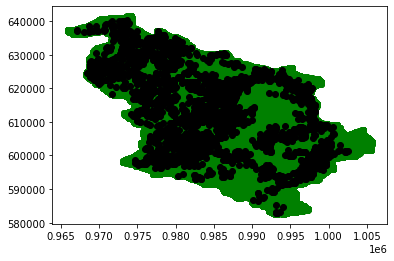

In [18]:
plt.scatter(df_full_1['coord_x'],df_full_1['coord_y'],color='g')
plt.scatter(derrumbes_df['Coord_Este'],derrumbes_df['Coord_Nort'],color='k')
plt.show()

<AxesSubplot:xlabel='partition', ylabel='Count'>

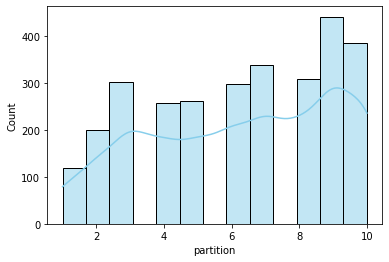

In [92]:
sns.histplot(data=derrumbes_df, x="partition", kde=True, color="skyblue",stat='count')

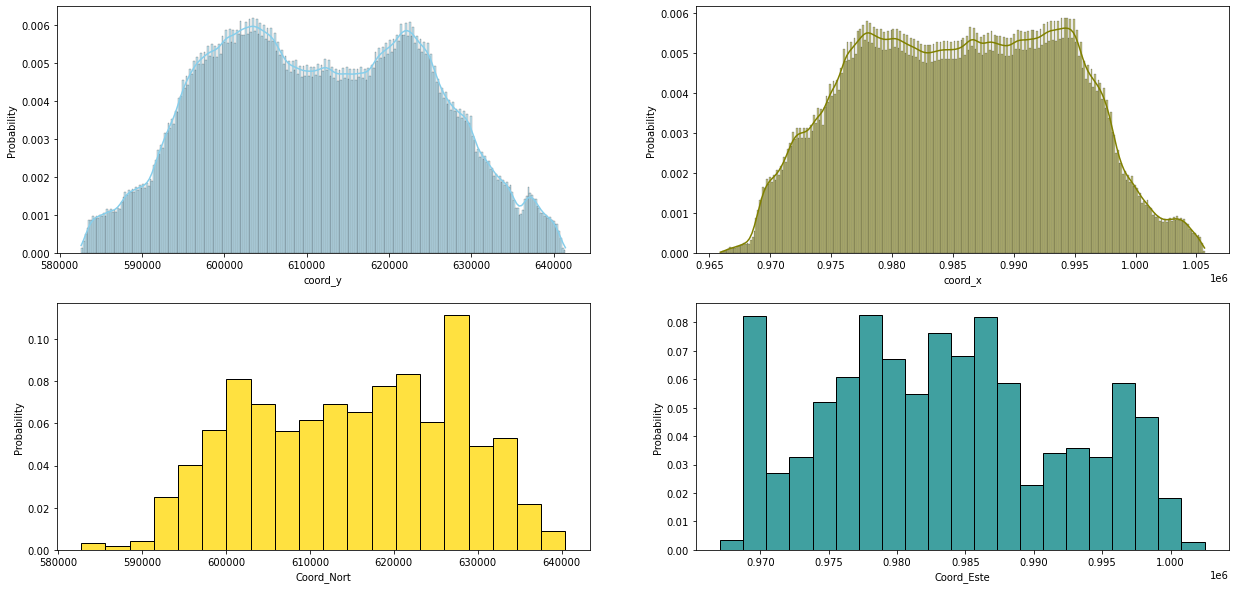

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(21, 10))
sns.histplot(data=df_full_1, x="coord_y", kde=True, color="skyblue",stat='probability', ax=axs[0, 0])
sns.histplot(data=df_full_1, x="coord_x", kde=True, color="olive",stat='probability', ax=axs[0, 1])
sns.histplot(data=derrumbes_df, x='Coord_Nort', kde=False, color="gold",stat='probability', ax=axs[1, 0])
sns.histplot(data=derrumbes_df, x='Coord_Este', kde=False, color="teal",stat='probability', ax=axs[1, 1])
plt.show()

## Match data

   * Filter partition of "slides_ls"
   * Filter partition of "df_full_1"
   * Execute cell below
   * Change name of csv file and execute    

In [19]:
# Change partition number |------- HERE ----------|
slides_ls = derrumbes_df[derrumbes_df.partition==4][['OBJECTID','partition','Coord_Nort','Coord_Este']]
slides_ls['ON'] = True
slides_cnt = sum(slides_ls['ON'])
print(f"varibale de control: {slides_cnt}")
def landslides(coord_x, coord_y, part):
    global slides_cnt
    is_slide = [False, 0.0]
    #slides_short = slides_ls[slides_ls['partition'] == part]
    if slides_cnt != 0:
        #print(f'searching on partition {part}')
        for index, row in slides_ls.iterrows():
            if row['ON'] == True:
                if (coord_x-6.25) <= row['Coord_Este'] <= (coord_x+6.25):
                    if (coord_y-6.25) <= row['Coord_Nort'] <= (coord_y+6.25):
                        is_slide = [True, row['OBJECTID']]
                        slides_ls.at[index,'ON'] = False
                        slides_cnt = sum(slides_ls['ON'])
                        #print(f"found one: {is_slide[1]}")
                        print(f"varibale de control: {sum(slides_ls['ON'])}")
                        break
    return is_slide

varibale de control: 257


In [20]:
start = datetime.datetime.now()
#Change partition number |---- HERE ----|
cruces = df_full_1[df_full_1.partition==4].apply(lambda x: landslides(x['coord_x'], x['coord_y'],x['partition']), axis=1)
finish = datetime.datetime.now()
print(f'total ejecucion {finish-start}')

varibale de control: 256
varibale de control: 255
varibale de control: 254
varibale de control: 253
varibale de control: 252
varibale de control: 251
varibale de control: 250
varibale de control: 249
varibale de control: 248
varibale de control: 247
varibale de control: 246
varibale de control: 245
varibale de control: 244
varibale de control: 243
varibale de control: 242
varibale de control: 241
varibale de control: 240
varibale de control: 239
varibale de control: 238
varibale de control: 237
varibale de control: 236
varibale de control: 235
varibale de control: 234
varibale de control: 233
varibale de control: 232
varibale de control: 231
varibale de control: 230
varibale de control: 229
varibale de control: 228
varibale de control: 227
varibale de control: 226
varibale de control: 225
varibale de control: 224
varibale de control: 223
varibale de control: 222
varibale de control: 221
varibale de control: 220
varibale de control: 219
varibale de control: 218
varibale de control: 217


In [21]:
# validate
sum(pd.DataFrame(np.row_stack(cruces))[0])

256.0

In [22]:
#Change csv file name |--HERE--|
cruces.to_csv('slides_df_4.csv', sep=';', encoding='utf-8')

# END

In [15]:
slides_path = glob.glob("slides\slides*.csv")
slides_path

['slides\\slides_df_1.csv',
 'slides\\slides_df_2.csv',
 'slides\\slides_df_3.csv',
 'slides\\slides_df_4.csv',
 'slides\\slides_df_5.csv',
 'slides\\slides_df_6.csv',
 'slides\\slides_df_7.csv',
 'slides\\slides_df_8.csv',
 'slides\\slides_df_9_10.csv']

In [35]:
slides_ls = []

for filename in slides_path:
    df = pd.read_csv(filename, sep=';',encoding='utf-8',index_col=0)
    slides_ls.append(df)

slides_df = pd.concat(slides_ls, axis=0, ignore_index=False)
slides_df.rename({'0':'val'},axis=1,inplace=True)
slides_df

C:\Users\gvargasj\.conda\envs\MINE-DS\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,val
4221229,"[False, 0.0]"
4225934,"[False, 0.0]"
4225935,"[False, 0.0]"
4225936,"[False, 0.0]"
4225937,"[False, 0.0]"
...,...
11204054,"[False, 0.0]"
11208759,"[False, 0.0]"
11208760,"[False, 0.0]"
11208761,"[False, 0.0]"


In [36]:
slides_df = pd.DataFrame(slides_df['val'].apply(literal_eval))
slides_df = slides_df.val.apply(pd.Series)
slides_df 

,0,1
4221229,False,0.0
4225934,False,0.0
4225935,False,0.0
4225936,False,0.0
4225937,False,0.0
...,...,...
11204054,False,0.0
11208759,False,0.0
11208760,False,0.0
11208761,False,0.0


In [41]:
slides_df[0].sum()

2905

In [153]:
df_full_2 = pd.merge(df_full_1, slides_df, how="left", left_index=True, right_index=True)
df_full_2.rename({0:'is_slide', 1: 'slide_FK'},axis=1,inplace=True)
df_full_2.drop(['partition','slide_key'], inplace=True, axis=1)
#df_full_2['is_duplicate'] = df_full_2.duplicated(keep=False)
df_full_2 = df_full_2[(df_full_2.index.duplicated(keep=False)==False)|((df_full_2.index.duplicated(keep=False)==True) & (df_full_2.is_slide==True))]
df_full_2 = df_full_2[(df_full_2.Slope>5.0)&(~df_full_2.Cobertura.isin([20,21,22]))]
df_full_2['is_slide'] = df_full_2['is_slide'].fillna(False)
df_full_2['slide_FK'] = df_full_2['slide_FK'].fillna(0.0)
df_full_2 #5029969

,coord_y,coord_x,Cobertura,Curvatura,Distancia_Drenajes,Distancia_Fallas,Distancia_Vias,DTM,Geologia,Geomorfologia,NDVI,Orientaciones,Rugosidad,Slope,TPI,UGS,is_slide,slide_FK
348,637085.126257,9.658990e+05,7.0,-1.972500,80.039055,8860.463867,37.500000,2551.359131,7.0,12.0,0.209492,355.292999,255.0,5.959947,15.154297,8.0,False,0.0
349,637072.626257,9.658990e+05,7.0,1.644063,88.388351,8852.268555,25.000000,2554.278564,7.0,12.0,0.209492,14.471906,255.0,6.341040,17.635742,8.0,False,0.0
5053,637110.126257,9.659115e+05,7.0,2.063750,72.886902,8867.470703,63.737743,2547.096191,7.0,12.0,0.209140,63.449421,255.0,13.375040,12.150391,8.0,False,0.0
5054,637097.626257,9.659115e+05,7.0,2.821250,80.039055,8859.246094,51.538822,2549.342041,7.0,12.0,0.209140,48.567108,255.0,14.689607,13.618164,8.0,False,0.0
5055,637085.126257,9.659115e+05,7.0,2.158594,88.388351,8851.033203,39.528469,2551.521729,7.0,12.0,0.209492,40.382771,255.0,13.636049,15.251465,8.0,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14971278,603710.126257,1.005649e+06,15.0,0.408594,290.742584,5834.059570,4161.824219,3435.000000,7.0,68.0,0.065119,174.213181,157.0,8.412902,4.165771,40.0,False,0.0
14971279,603697.626257,1.005649e+06,15.0,0.320000,279.508484,5825.120605,4167.020996,3433.000000,7.0,68.0,0.065119,183.168121,255.0,7.847511,2.727783,40.0,False,0.0
14971280,603685.126257,1.005649e+06,15.0,-0.411406,268.386383,5816.194824,4172.248535,3431.000000,7.0,68.0,0.065119,183.126923,255.0,6.475584,1.312500,40.0,False,0.0
14975985,603710.126257,1.005661e+06,15.0,0.342500,285.591492,5842.797363,4173.203125,3434.761719,7.0,68.0,0.065119,177.147964,255.0,6.341611,3.147949,40.0,False,0.0


In [154]:
df_full_2.is_slide.sum() # 2186 2440

2440

In [156]:
df_full_2.to_csv('dataset_3.csv', sep=';', encoding='utf-8')
#df_full_2.to_csv('dataset_2.csv', sep=';', encoding='latin-1') 

In [ ]:
img_data['Rugosidad'].plot()

In [ ]:
# View generate metadata associated with the raster file
print("The crs of your data is:", pre_lidar_dem.rio.crs)
print("The nodatavalue of your data is:", pre_lidar_dem.rio.nodata)
print("The shape of your data is:", pre_lidar_dem.shape)
print("The spatial resolution for your data is:", pre_lidar_dem.rio.resolution())
print("The metadata for your data is:", pre_lidar_dem.attrs)